# Fisher's linear discriminant

- Author: Zhihan Yang
- Date: Friday, March 27, 2020

In [31]:
import numpy as np
from scipy.stats import multivariate_normal
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train.reshape(len(x_train), 28 * 28)
x_test = x_test.reshape(len(x_test), 28 * 28)

## Reduce data dimension

Motivation for PCA before LDA: https://stats.stackexchange.com/questions/247720/why-is-within-class-scatter-matrix-in-lda-singular

In [4]:
pca = PCA(n_components=50).fit(x_train)
# use PCA(0.90).fit(x_train) and then pca.n_components_
# to search for the appropriate number of components without significant compression

In [5]:
x_train_transformed, x_test_transformed = pca.transform(x_train), pca.transform(x_test)

In [6]:
x_train_transformed.shape, x_train_transformed.max(), x_train_transformed.min()

((60000, 50), 2363.32405537362, -1507.4220234441318)

In [7]:
ones = x_train_transformed[y_train == 1]
ones_test = x_test_transformed[y_test == 1]
one_labels = np.zeros(len(ones))

sevens = x_train_transformed[y_train == 7]
sevens_test = x_test_transformed[y_test == 7]
seven_labels = np.zeros(len(sevens))

In [8]:
ones.shape, sevens.shape

((6742, 50), (6265, 50))

## Compute Fisher's linear discriminant

Fisher's linear discrimiant is proportional to:
$$\vec{w} = S_W (\vec{m}_2 - \vec{m}_1)$$

Compute $\vec{m}_2$ and $\vec{m}_1$:

In [9]:
m1 = np.mean(ones, axis=0)
m2 = np.mean(sevens, axis=0)
m1.shape, m2.shape

((50,), (50,))

Compute $S_W$ using vectorization:

$$S_{W} = \sum_{n \in C_{1}}\left(\vec{x}^{n}-\vec{m}_{1}\right)\left(\vec{x}^{n}-\vec{m}_{1}\right)^{T}+\sum_{n \in C_{2}}\left(\vec{x}^{n}-\vec{m}_{2}\right)\left(\vec{x}^{n}-\vec{m}_{2}\right)^{T}$$

- `ones`: $n_1$ by 784
- `m1`: 784 (broadcasted to $n_1$ by 784)
- Draw matrix diagrams on a piece of paper and you will understand this vectorization immediately.

In [10]:
Sw = (ones - m1).T @ (ones - m1) + (sevens - m2).T @ (sevens - m2)

In [11]:
Sw.shape, Sw.max(), Sw.min()

((50, 50), 1731108116.2450194, -616938063.6365619)

Compute $\vec{w}$ using an arbitrarily chosen proportionality constant of 1:

In [12]:
w = np.linalg.inv(Sw) @ (m2 - m1).reshape(-1, 1)
w.shape

(50, 1)

Project data onto $\vec{w}$:

In [13]:
ones_train_proj = ones @ w
sevens_train_proj = sevens @ w

In [14]:
ones_test_proj = ones_test @ w
sevens_test_proj = sevens_test @ w

Plot the distribution of (scalar) projections:

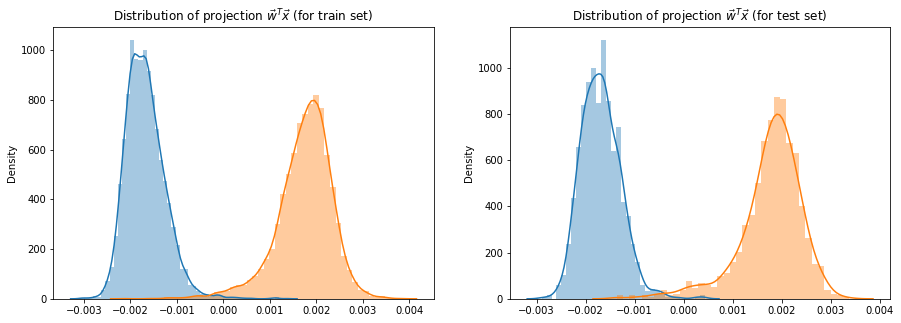

In [35]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)

sns.distplot(ones_train_proj)
sns.distplot(sevens_train_proj)

plt.title(r'Distribution of projection $\vec{w}^T \vec{x}$ (for train set)')
plt.ylabel('Density')

fig.add_subplot(122)

sns.distplot(ones_test_proj)
sns.distplot(sevens_test_proj)

plt.title(r'Distribution of projection $\vec{w}^T \vec{x}$ (for test set)')
plt.ylabel('Density')

plt.show()

## Maximum likelihood for normal distributions

From Bishop 1995, the maximum likelihood estimate of the mean and the covariance matrix of a normal distribution given a set of data points $\vec{x}^n$, is given by:

- Mean: $\widehat{\boldsymbol{\mu}}=\frac{1}{N} \sum_{n=1}^{N} \mathbf{x}^{n}$
- Covariance matrix: $\widehat{\mathbf{\Sigma}}=\frac{1}{N} \sum_{n=1}^{N}\left(\mathbf{x}^{n}-\widehat{\boldsymbol{\mu}}\right)\left(\mathbf{x}^{n}-\widehat{\boldsymbol{\mu}}\right)^{\mathrm{T}}$

Mean and covariance matrix for ones:

In [86]:
mean_est_ones = np.mean(ones_train_proj)
covar_est_ones = 1 / len(ones_train_proj) * ((ones_train_proj - mean_est_ones).T @ (ones_train_proj - mean_est_ones))

In [87]:
xs_ones = np.linspace(ones_train_proj.min(), ones_train_proj.max(), 200)
rvs_ones= multivariate_normal(mean=mean_est_ones, cov=covar_est_ones)
densities_ones = rvs_ones.pdf(xs_ones)

Mean and covariance matrix for sevens.

In [88]:
mean_est_sevens = np.mean(sevens_train_proj)
covar_est_sevens = 1 / len(sevens_train_proj) * ((sevens_train_proj - mean_est_sevens).T @ (sevens_train_proj - mean_est_sevens))

In [89]:
xs_sevens = np.linspace(sevens_train_proj.min(), sevens_train_proj.max(), 200)
rvs_sevens = multivariate_normal(mean=mean_est_sevens, cov=covar_est_sevens)
densities_sevens = rvs_sevens.pdf(xs_sevens)

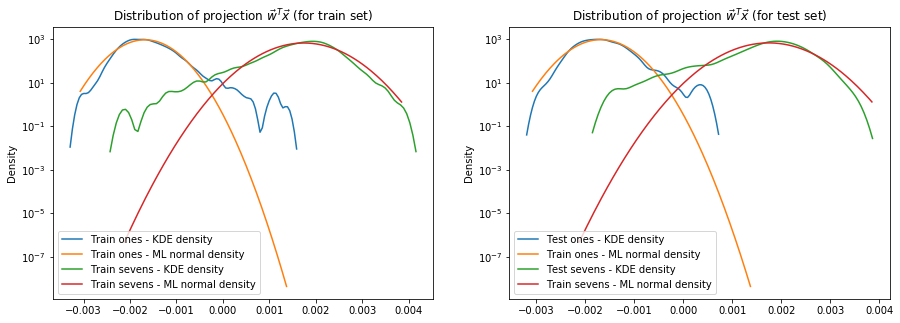

In [108]:
fig = plt.figure(figsize=(15, 5))

# subplot 1

fig.add_subplot(121)

sns.kdeplot(ones_train_proj.flatten(), label='Train ones - KDE density')
plt.plot(xs_ones, densities_ones, label='Train ones - ML normal density')

sns.kdeplot(sevens_train_proj.flatten(), label='Train sevens - KDE density')
plt.plot(xs_sevens, densities_sevens, label='Train sevens - ML normal density')

plt.title(r'Distribution of projection $\vec{w}^T \vec{x}$ (for train set)')
plt.ylabel('Density')
plt.yscale('log')

plt.legend()

# subplot 2

fig.add_subplot(122)

sns.kdeplot(ones_test_proj.flatten(), label='Test ones - KDE density')
plt.plot(xs_ones, densities_ones, label='Train ones - ML normal density')

sns.kdeplot(sevens_test_proj.flatten(), label='Test sevens - KDE density')
plt.plot(xs_sevens, densities_sevens, label='Train sevens - ML normal density')

plt.yscale('log')

plt.title(r'Distribution of projection $\vec{w}^T \vec{x}$ (for test set)')
plt.ylabel('Density')

plt.legend()

plt.show()

The y scale is logged to show differences between distributions in terms of small densities.

## Optimal threshold

The optimal threshold is the x-axis value above which the ML normal density for train ones crosses with the ML normal density for train sevens.

In [113]:
np.mean(rvs_ones.pdf(ones_test_proj) > rvs_sevens.pdf(ones_test_proj))

0.9955947136563876

In [114]:
np.mean(rvs_sevens.pdf(sevens_test_proj) > rvs_ones.pdf(sevens_test_proj))

0.9854085603112841